# Synthetic Control

This NB serves as a tutorial on how to run power analysis using synthetic control analysis. It considers that looking at some time frame and some clusters, one of the clusters will receive a treatment and the rest remain in control. This treatment cluster will receive some effect from the Perturbator. Then, we run a power analysis to understand how many times we can capture this perturbation.  

In the end we compare the results with Clustered OLS method. 

## Generate data

We will generate some random data with normal distribution of mean 10 and standard deviation of 10. 

In [84]:
# todo add point estimate at every iteration 

from itertools import product
import numpy as np
import pandas as pd
from cluster_experiments.experiment_analysis import SyntheticControlAnalysis, ClusteredOLSAnalysis
from cluster_experiments.perturbator import ConstantPerturbator
from cluster_experiments.power_analysis import PowerAnalysisWithPreExperimentData, PowerAnalysis
from cluster_experiments.random_splitter import FixedSizeClusteredSplitter
import plotnine as p9


def generate_data(N, start_date, end_date):
    dates = pd.date_range(start_date, end_date, freq="d")

    users = [f"User {i}" for i in range(N)]

    combinations = list(product(users, dates))

    target_values = np.random.normal(100, 10, size=len(combinations))

    df = pd.DataFrame(combinations, columns=["user", "date"])
    df["target"] = target_values


    return df



In [85]:
df = generate_data(20, "2022-01-01", "2022-01-30")
intervention_date = "2022-01-15"
effects = [0, 1, 5, 10, 20]



The graph below shows the evolution of target for each user. When running the synthetic control analysis:
- Select randomly one user to be in treatment group. 
- Use pre experiment data (in this case case from 1 to 15th of Jan) to find the best combination of weights 
- Apply weights to donors and generate synthetic control user 

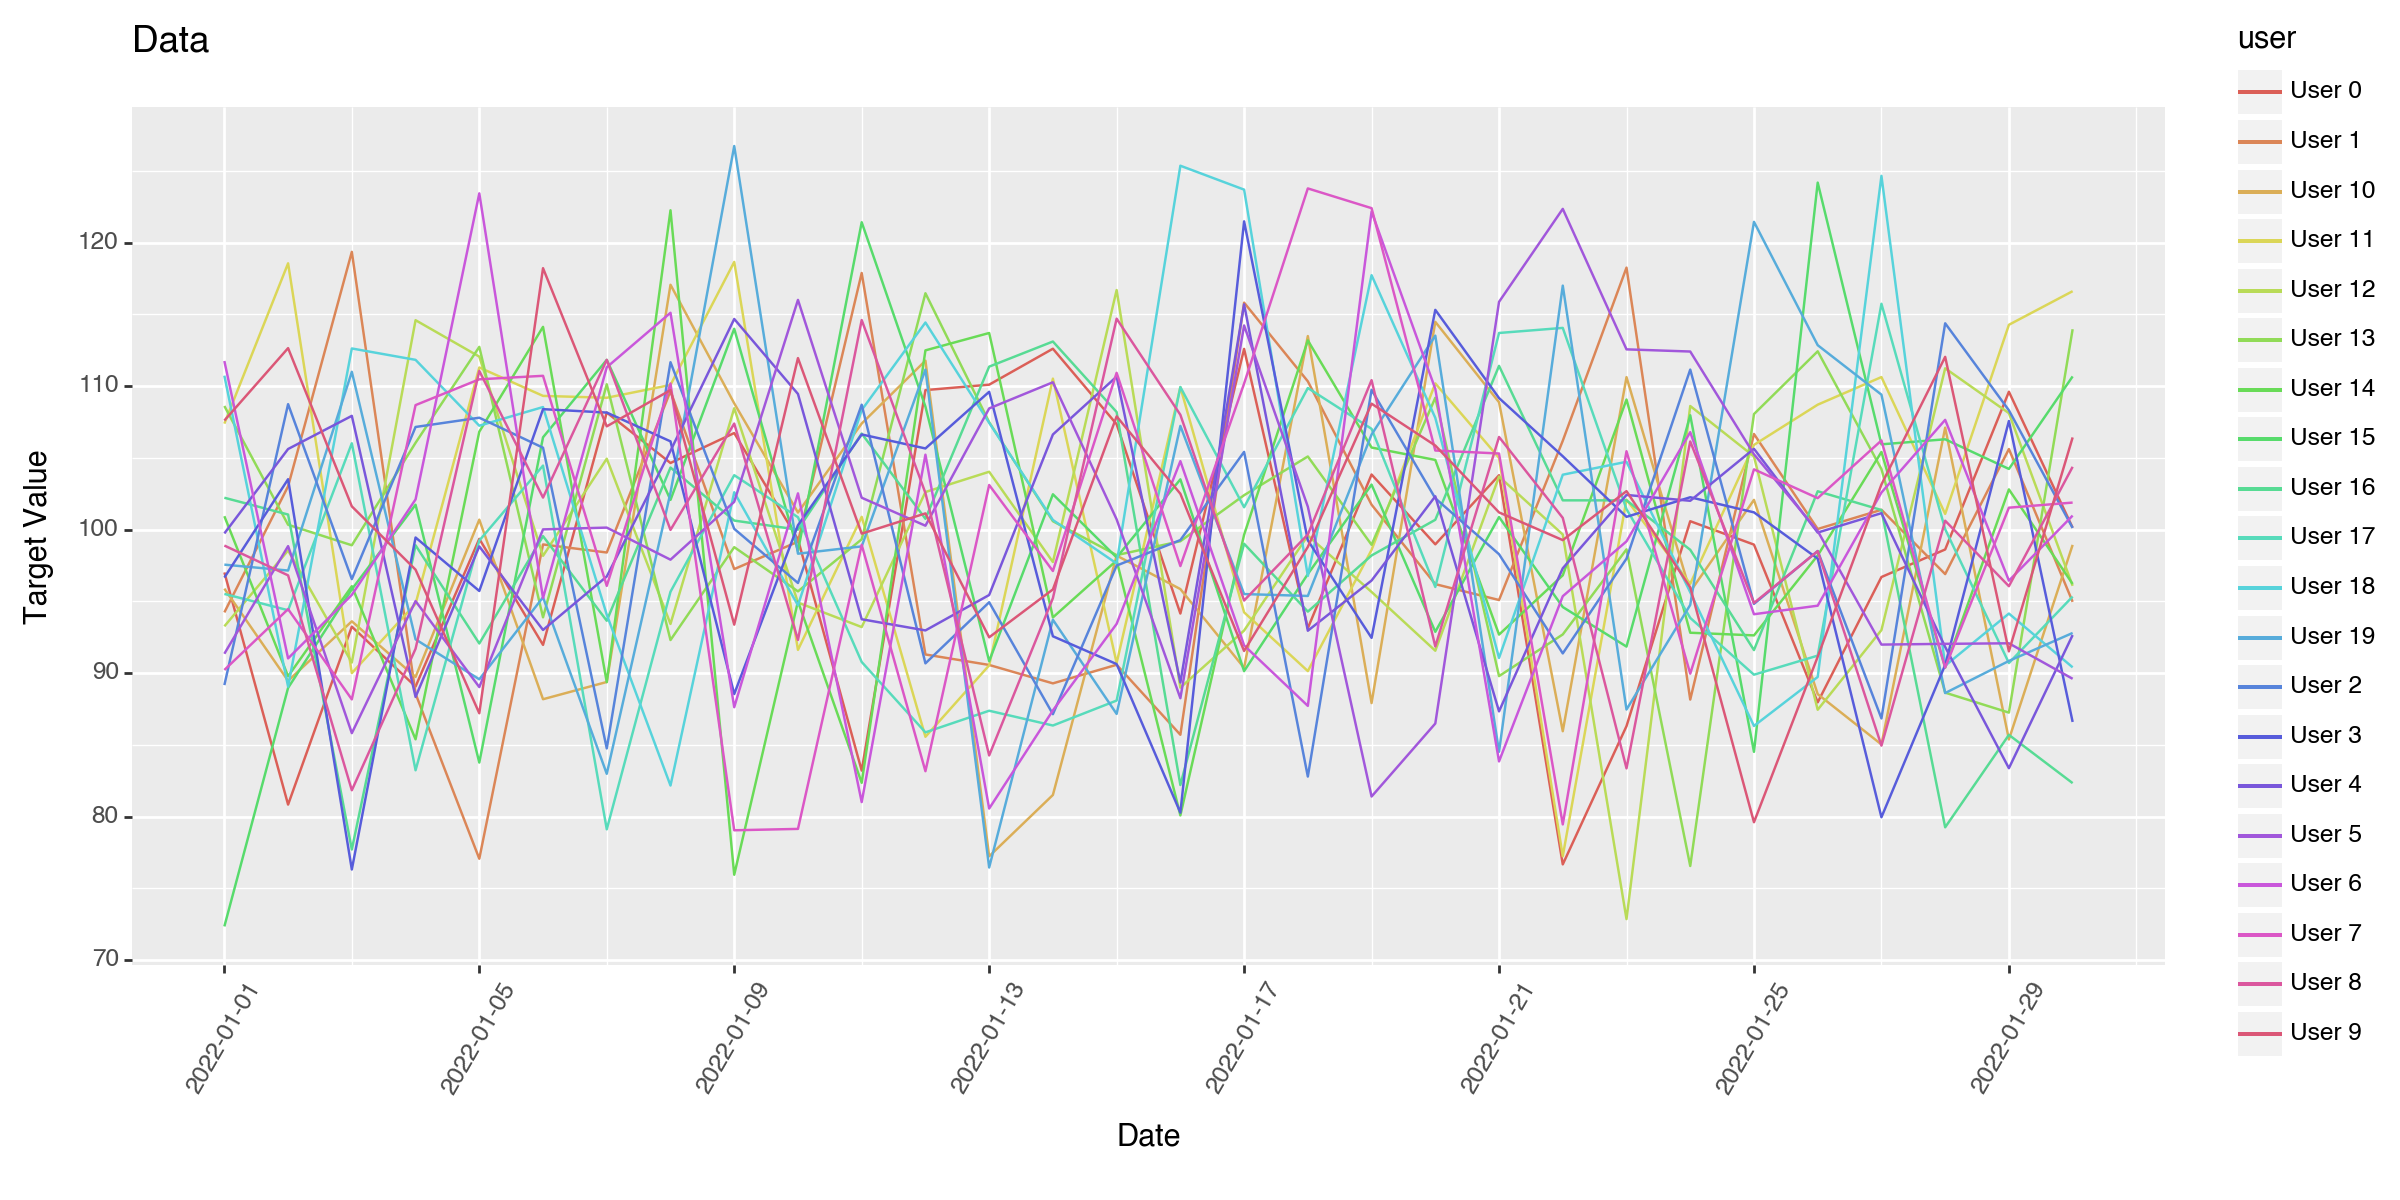

<Figure Size: (1200 x 600)>

In [86]:
(p9.ggplot(df, p9.aes(x="date", y="target", color = 'user')) 
 + p9.geom_line() 
 + p9.labs(title="Data", x="Date", y="Target Value") 
 + p9.theme(axis_text_x=p9.element_text(angle=60), figure_size=(12, 6)))


In [87]:
df

,user,date,target
0,User 0,2022-01-01,97.016355
1,User 0,2022-01-02,80.842119
2,User 0,2022-01-03,93.238889
3,User 0,2022-01-04,89.067074
4,User 0,2022-01-05,99.355975
...,...,...,...
595,User 19,2022-01-26,112.846508
596,User 19,2022-01-27,109.401372
597,User 19,2022-01-28,88.612896
598,User 19,2022-01-29,90.850274


# Point Estimates

In [88]:
sw = FixedSizeClusteredSplitter(n_treatment_clusters=1, cluster_cols=["user"])

perturbator = ConstantPerturbator(
    average_effect=10,
)

analysis = SyntheticControlAnalysis(
    cluster_cols=["user"], time_col="date", intervention_date=intervention_date
)

pw = PowerAnalysisWithPreExperimentData(
     splitter=sw, analysis=analysis, n_simulations=100, perturbator=perturbator
)





In [89]:
point_estimates = list(pw.simulate_point_estimate(df))

/Users/gabrielristow/PycharmProjects/cluster-experiments/.venv/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


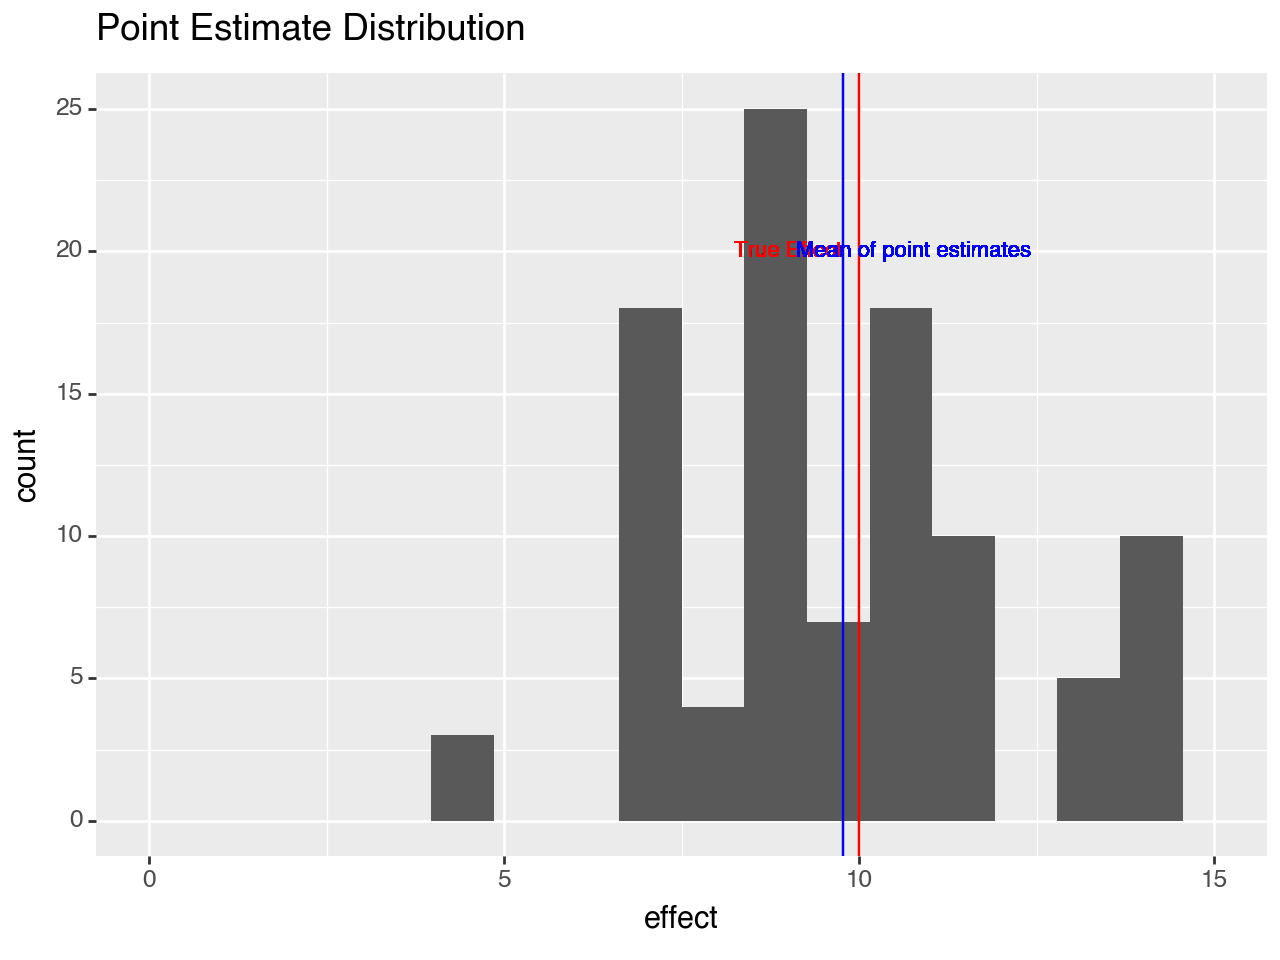

<Figure Size: (640 x 480)>

In [92]:
mean_pe = pd.Series(point_estimates).mean()

(p9.ggplot(pd.DataFrame(point_estimates, columns=["effect"]), p9.aes(x="effect"))
  + p9.geom_histogram(bins=18)
  + p9.scale_x_continuous(limits=(0, 15))
+ p9.labs(title = "Point Estimate Distribution")
+ p9.geom_vline(xintercept=10, color="red")
+ p9.geom_text(x=10-2, y=20, label="True Effect", color="red", size = 8)
+ p9.geom_vline(xintercept=mean_pe, color="blue")
+ p9.geom_text(x=mean_pe+2, y=20, label="Mean of point estimates", color="blue", size = 8)
)




# Power line and Comparison with OLS

This power line takes a long time to run because we calculate p values using a permutation test. 

In [ ]:
p_synth = pw.power_line(df, average_effects=effects)

In [ ]:
analysis = ClusteredOLSAnalysis(
    cluster_cols=["user"] )

pw = PowerAnalysis(
    perturbator=perturbator, splitter=sw, analysis=analysis, n_simulations=200
)

df = df.query(f"date > '{intervention_date}'")

p_ols = pw.power_line(df, average_effects=effects, n_jobs=5)

# todo add time to run 

In [ ]:
df_results = pd.DataFrame({'effect' :list(p_synth.keys()), 'power' : list(p_synth.values())})


In [ ]:
synth_df = pd.DataFrame({'effect' : p_synth.keys(), 
              'method': 'Synthetic',
              'power': p_synth.values()})

ols_df = pd.DataFrame({'effect' : p_ols.keys(), 
              'method': 'OLS',
              'power': p_ols.values()})

df_results = pd.concat([synth_df, ols_df])

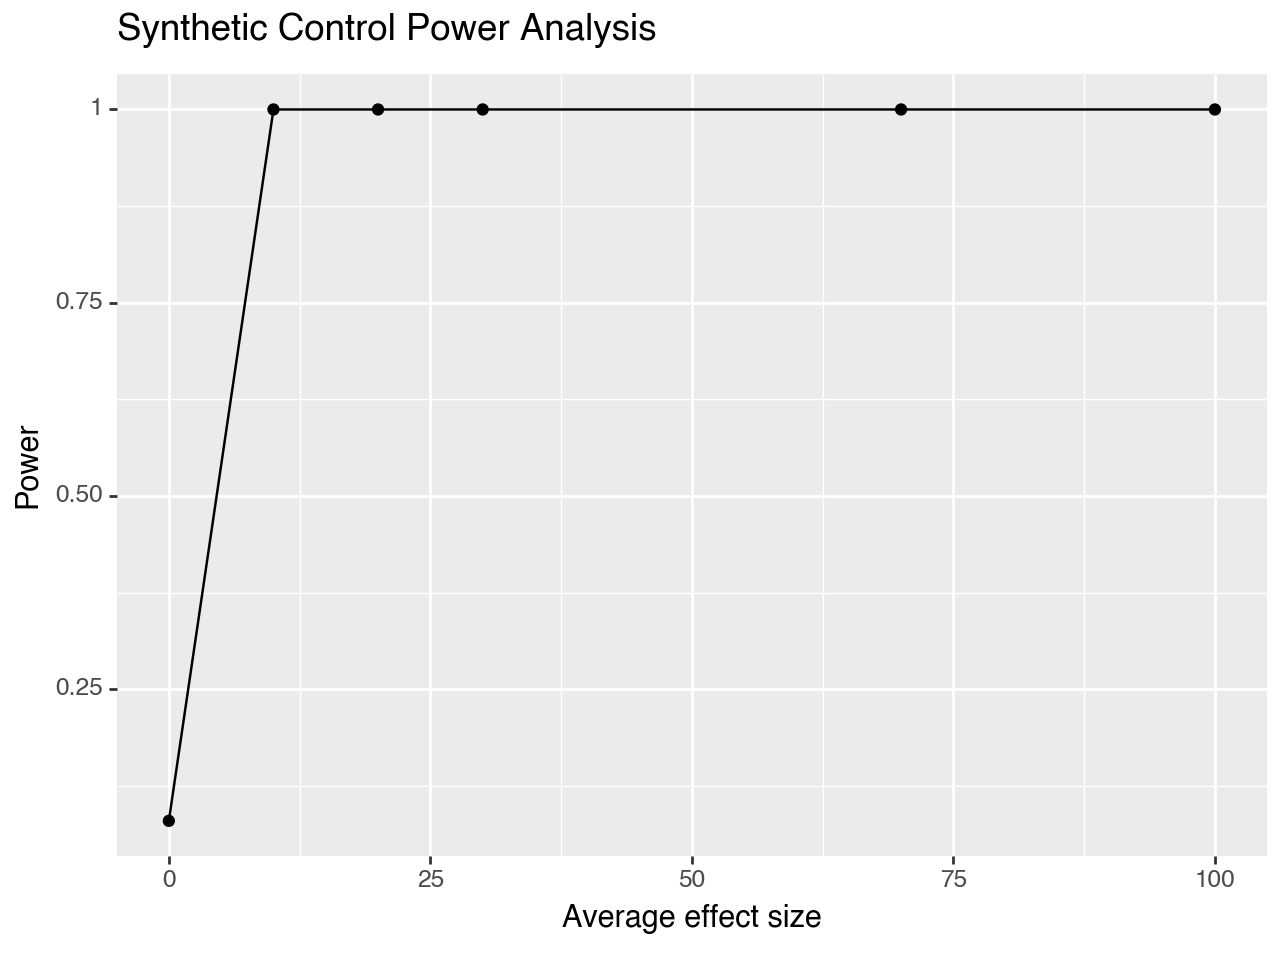

<Figure Size: (640 x 480)>

In [ ]:
(
p9.ggplot(df_results, p9.aes(x='effect', y='power')) 
+ p9.geom_line() 
+ p9.geom_point()
+ p9.labs(
    title="Synthetic Control Power Analysis",
    x="Average effect size", y="Power"
))

At first sight, we might think that OLS has more power than synthetic control. But we can clearly see that the OLS doesn't behave as expected when using only 1 treatment cluster. This gets clear when we see the power at 0 effect, in which should be equal to alpha (5% in this case).  
